## Classification Module for Telco-Churn Prediction

### Project Scenario

Every company wants to increase its profit or revenue margin and customer retention is one key area industry players focus their resources. In today's world of machine learning, most companies build classification models to perform churn analysis on their customers.

#### Hypothesis

- *Null Hypothesis (H0):* There is no significant relationship between the type of internet service (DSL, Fiber Optic, No) and customer churn.
- *Alternative Hypothesis (H1):* There is a significant relationship between the type of internet service (DSL, Fiber Optic, No) and customer churn.

### Analytical Questions

1. **What is the relationship between charges and customer churn?**

 - This question aims to understand if there is a significant association between the amount customers are charged and their likelihood of churning.


2. **What are the demographic characteristics of customers who are more likely to churn?**

 - This question seeks to identify the demographic factors (such as age, gender, income level, etc.) that are most common among customers who churn.


3. **What is the correlation between the Churn column and the other features?**

 - This question focuses on determining how each feature in the dataset correlates with customer churn, helping to identify which factors are most strongly associated with churn.


4. **Does the type of internet service influence customer churn?**

 - This question examines whether different types of internet services (e.g., DSL, Fiber optic, No internet service) have an impact on the likelihood of customers churning.


5. **Are customers with a longer tenure less likely to churn?**

 - This question investigates if there is a negative correlation between the length of time a customer has been with the company and their likelihood of churning.

6. **Does the payment method affect the churn rate?**

 - This question aims to find out if the method customers use to pay for services (e.g., electronic check, mailed check, bank transfer, credit card) influences their likelihood of churning.
    

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import pyodbc
import statsmodels.api as sm
from dotenv import dotenv_values

# Suppress all warnings
import warnings

warnings.filterwarnings("ignore")

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning package
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from scipy.stats import chi2_contingency
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV




### Connect to server

In [2]:
# load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials from .env file
database=environment_variables.get("databasename")
server=environment_variables.get("servername")
login=environment_variables.get("user")
password=environment_variables.get("password")

# create a connection string
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password}"

In [3]:
#Connecting to the Server
connection = pyodbc.connect(connection_string)

### View first DataFrame

In [4]:
# Loading First dataset 3000 records
first_data = pd.read_sql_query(
    "SELECT * FROM dbo.LP2_Telco_churn_first_3000", connection)

# Saving the DataFrame to a CSV file
first_data.to_csv('data/LP2_Telco_churn_first_3000.csv', index=False)

first_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [5]:
#Check shape of first_dataset
first_data.shape

(3000, 21)

### Load Second dataset

In [6]:
second_data= pd.read_csv('data/LP2_Telco-churn-second-2000.csv')

#Data preview
second_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [7]:
#Check shape of second_data
second_data.shape

(2043, 21)

### Look into Test dataset

In [8]:
# Loading Test data
test_data = pd.read_excel('data\Telco-churn-last-2000.xlsx')

# Data preview
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


### Merge first and second datasets into one DataFrame

In [9]:
#Merge dataset
#merged_df= pd.concat([first_data, second_data])
#merged_df.to_csv('merged_df.csv')

In [10]:
# Loading merged_df.csv
merged= pd.read_csv('data\merged_df.csv')

# Data preview
merged.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000381469727,False
1,1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.1500015258789,True
3,3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.64999389648438,True


### Explore data characteristics

In [11]:
#Check shape of merged_data
merged.shape

(5043, 22)

In [12]:
#Check merge data info
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5043 non-null   int64  
 1   customerID        5043 non-null   object 
 2   gender            5043 non-null   object 
 3   SeniorCitizen     5043 non-null   int64  
 4   Partner           5043 non-null   object 
 5   Dependents        5043 non-null   object 
 6   tenure            5043 non-null   int64  
 7   PhoneService      5043 non-null   object 
 8   MultipleLines     4774 non-null   object 
 9   InternetService   5043 non-null   object 
 10  OnlineSecurity    4392 non-null   object 
 11  OnlineBackup      4392 non-null   object 
 12  DeviceProtection  4392 non-null   object 
 13  TechSupport       4392 non-null   object 
 14  StreamingTV       4392 non-null   object 
 15  StreamingMovies   4392 non-null   object 
 16  Contract          5043 non-null   object 


### Drop irrelevant columns

In [13]:
#Drop irrelevant column from merged_data
merged = merged.drop('Unnamed: 0', axis = 'columns')

In [14]:
#Confirm dropped column from merged_DataFrame
merged.shape

(5043, 21)

### Confirm remaining columns from merged_DataFrame

In [15]:
#Check column names in merged_DataFrame
merged.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

### Check dtype of merged_DataFrame

In [16]:
#Checking the data types of the columns
merged.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [17]:
merged.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


- Only about `16.24%` of the customers are senior citizens, suggesting that the company’s customer base is predominantly younger. whereas the `median tenure is 29 months`, indicating that half of the customers stay for `less than 2.5 years`. That not withstanding, the 25th percentile for monthly charges is `$35.78`, while the 75th percentile is `$90.05`. This spread indicates a significant difference in what customers are willing to pay.

In [18]:
# Check for duplicates in merged_data
duplicate_rows = merged.duplicated().sum()

# Print the number of duplicate rows
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


### Check unique values in each column

In [19]:
# loop through columns in training data
for column in merged.columns:
 
    #check if the column is not a numerical column
    if (merged[column].dtype not in ['int64', 'float64']):
 
        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {merged[column].unique()}')
        print(70 * '-')

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: Partner
unique values: ['True' 'False' 'No' 'Yes']
----------------------------------------------------------------------
column: Dependents
unique values: ['False' 'True' 'No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: ['False' 'True' 'Yes' 'No']
----------------------------------------------------------------------
column: MultipleLines
unique values: [nan 'False' 'True' 'No' 'No phone service' 'Yes']
----------------------------------------------------------------------
column: InternetService
unique values: ['DSL' 'Fiber optic' 'No']
--------------------------------------------------------------------

### Asign right dtype to TotalCharges

In [20]:
merged.TotalCharges = pd.to_numeric(merged.TotalCharges, errors='coerce')
merged.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

### Drop missing value in Churn column

In [21]:
# Drop missing value from churn
merged.dropna(subset=['Churn'], inplace=True)


### Unify column characteristics 

In [22]:
# Replace 'True' with 'Yes' and 'False' with 'No'
merged.replace({'True': 'Yes', 'False': 'No'}, inplace=True)

In [23]:
# loop through columns in training data
for column in merged.columns:
 
    #check if the column is not a numerical column
    if (merged[column].dtype not in ['int64', 'float64']):
 
        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {merged[column].unique()}')
        print(70 * '-')

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: Partner
unique values: ['Yes' 'No']
----------------------------------------------------------------------
column: Dependents
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: MultipleLines
unique values: [nan 'No' 'Yes' 'No phone service']
----------------------------------------------------------------------
column: InternetService
unique values: ['DSL' 'Fiber optic' 'No']
----------------------------------------------------------------------
column: OnlineSecurity
unique values: ['No' 'Yes' nan 'No

### Univariate Analysis 

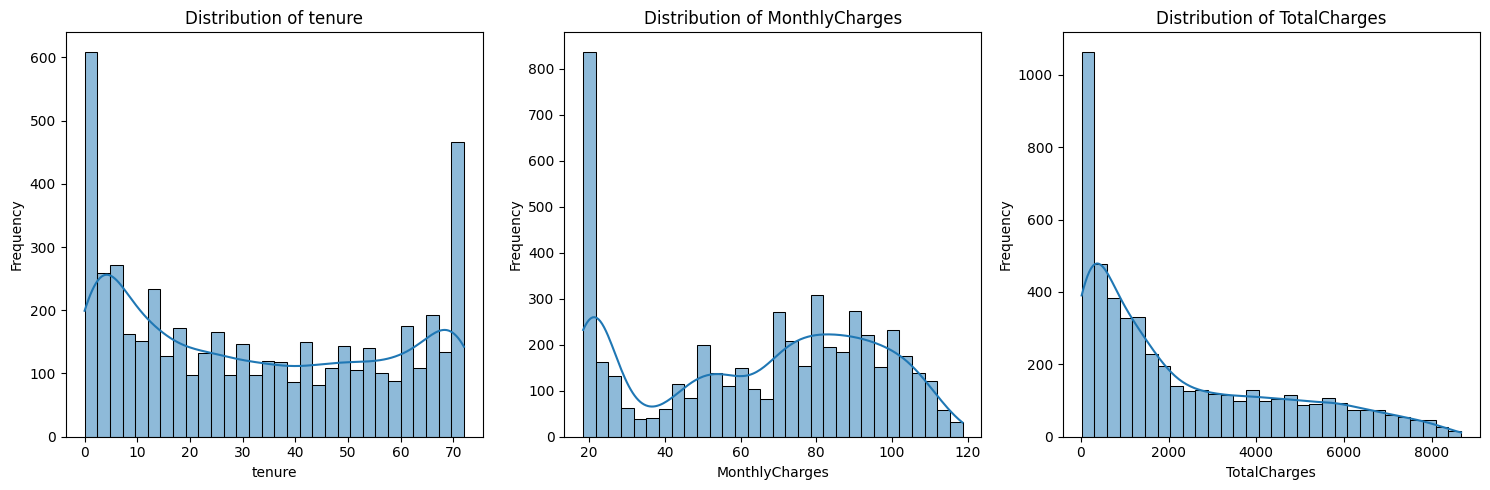

In [24]:
# Separate numerical columns
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(15, 5))

# Plot histograms for numerical columns in a grid view
for i, column in enumerate(numerical_columns):
    sns.histplot(data=merged, x=column, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

 - The numerical columns of the dataset are not normally distributed as graphically displayed, this will inform the kind of im[utatioon to be done to the datasets.]

### Check outliers

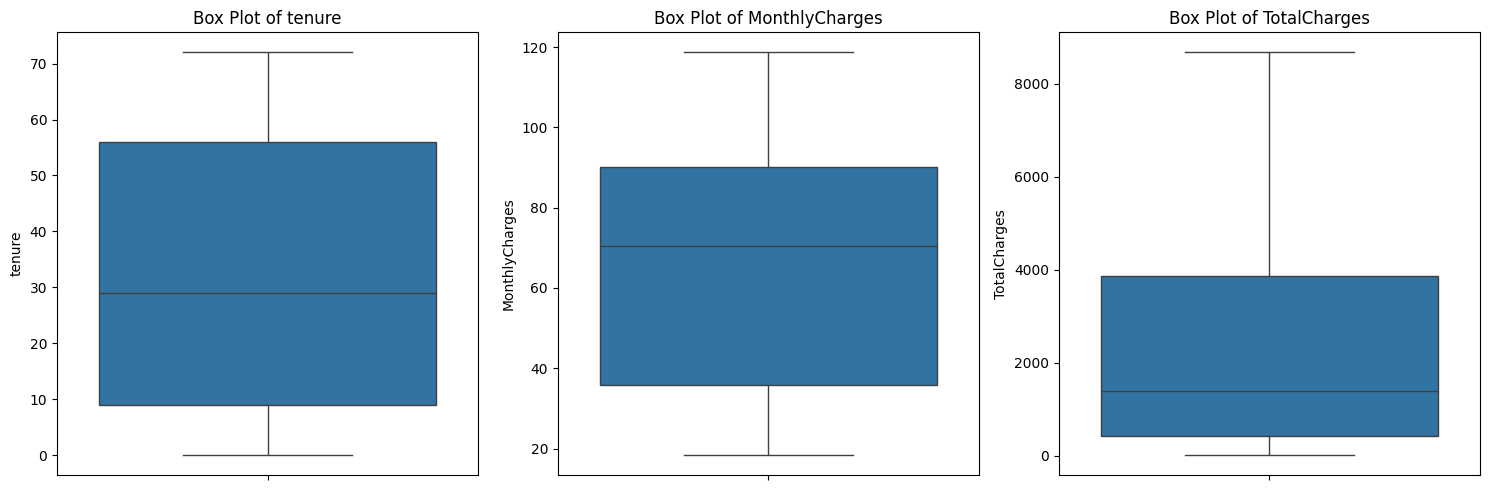

In [25]:
# focus on numerical columns
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create box plots
plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=merged[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()


 - The are no outliers in the dataset, hence imputing with either mean or median won't affect the model 

### Asign variable name to categorical columns

In [26]:
# Categorical Columns(Univariate)
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

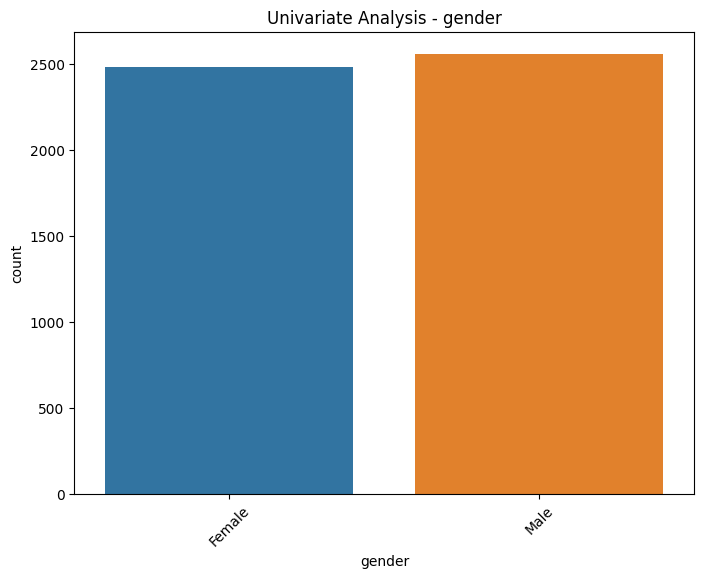

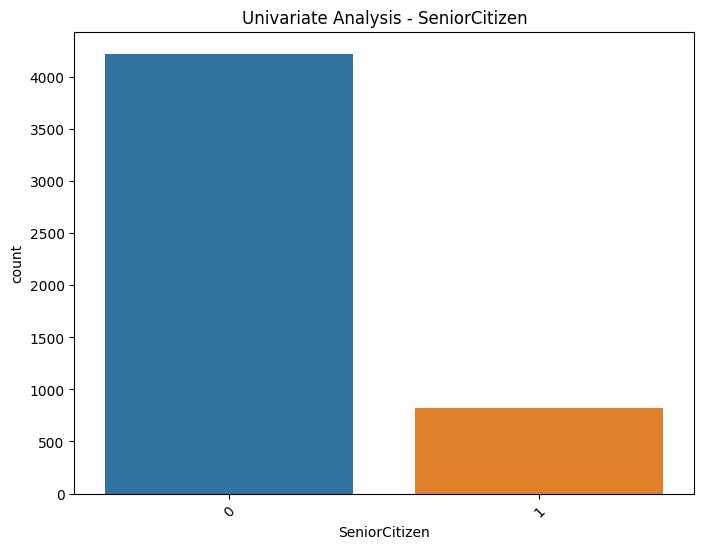

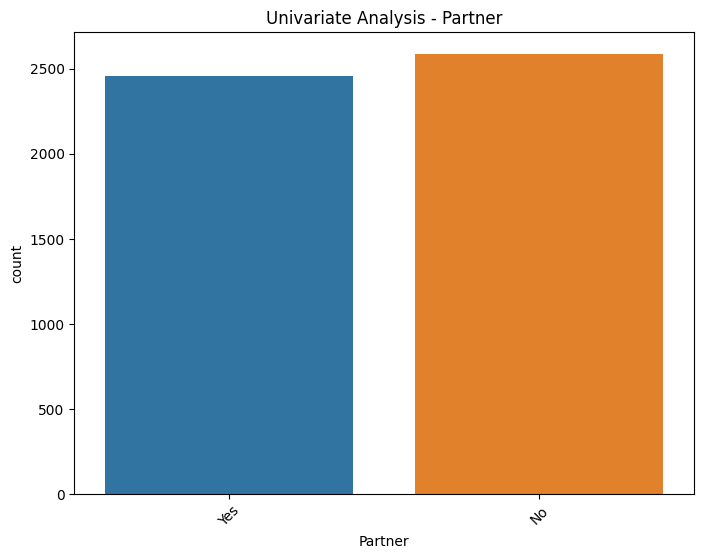

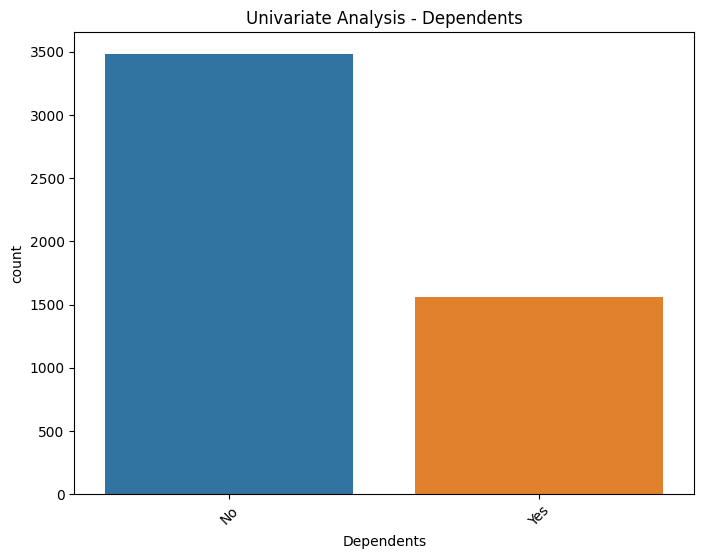

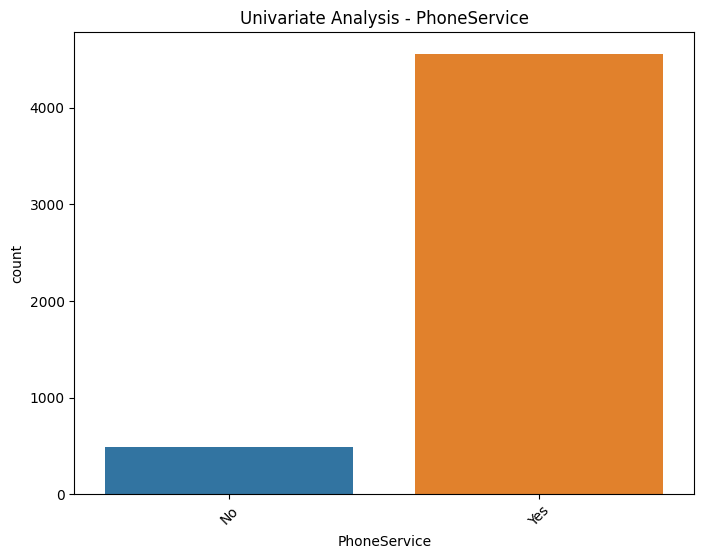

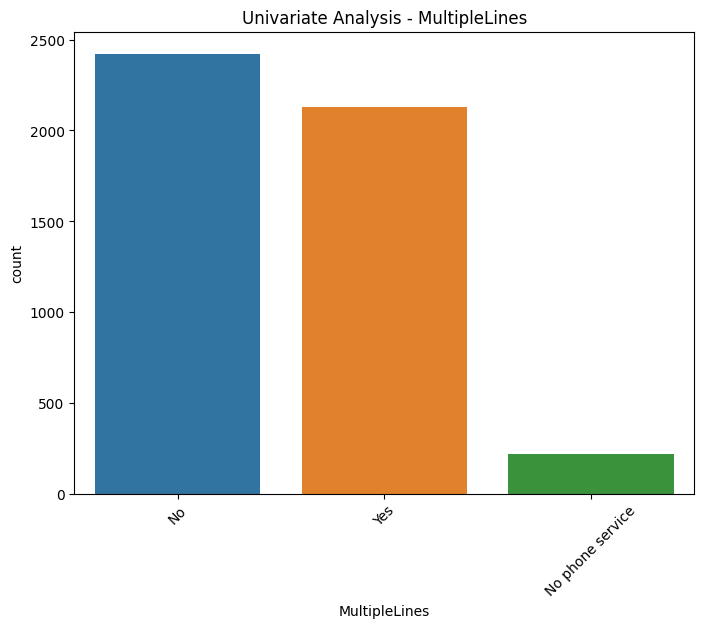

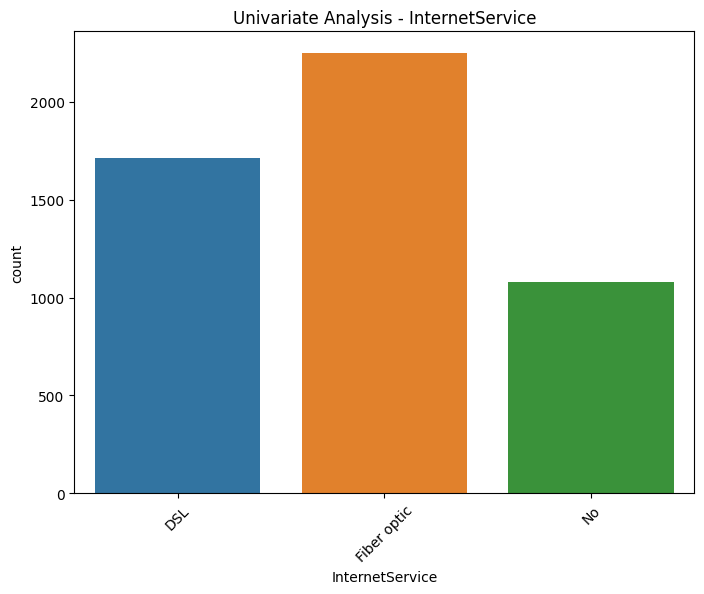

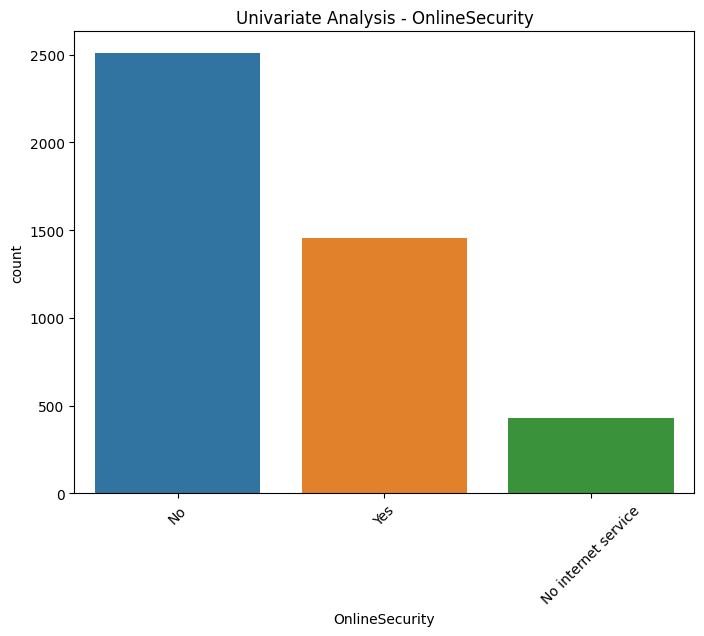

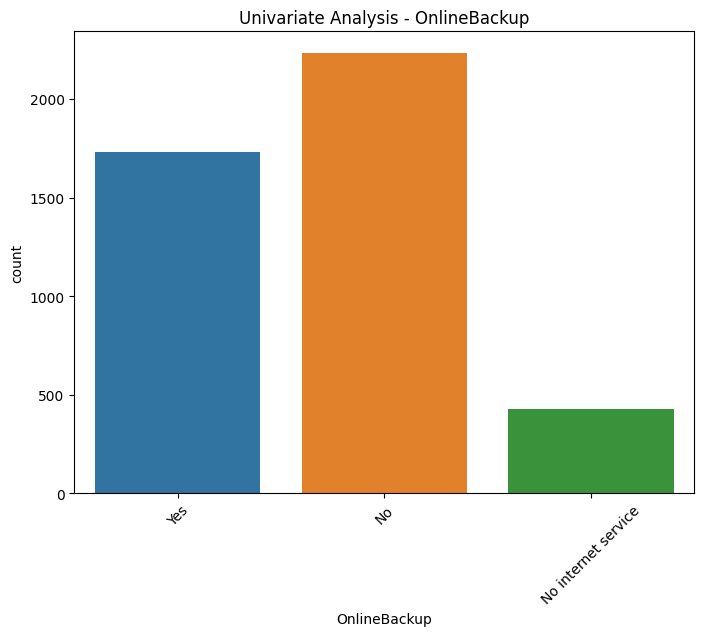

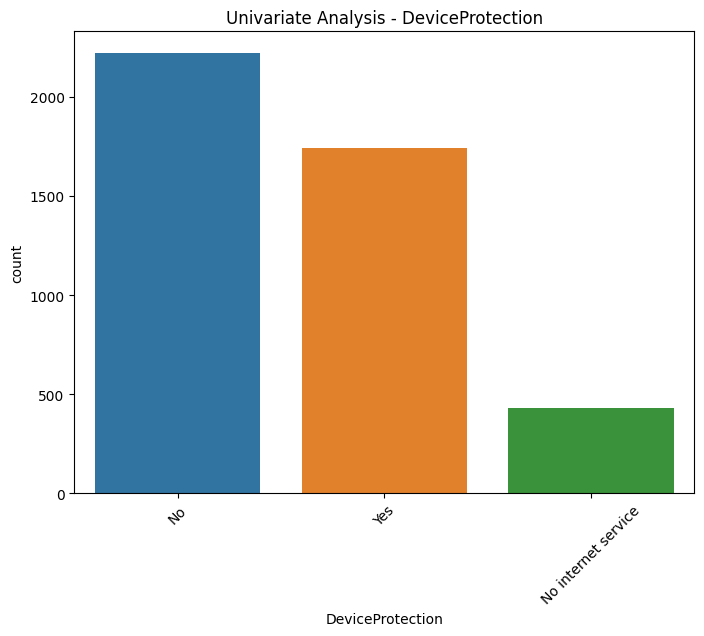

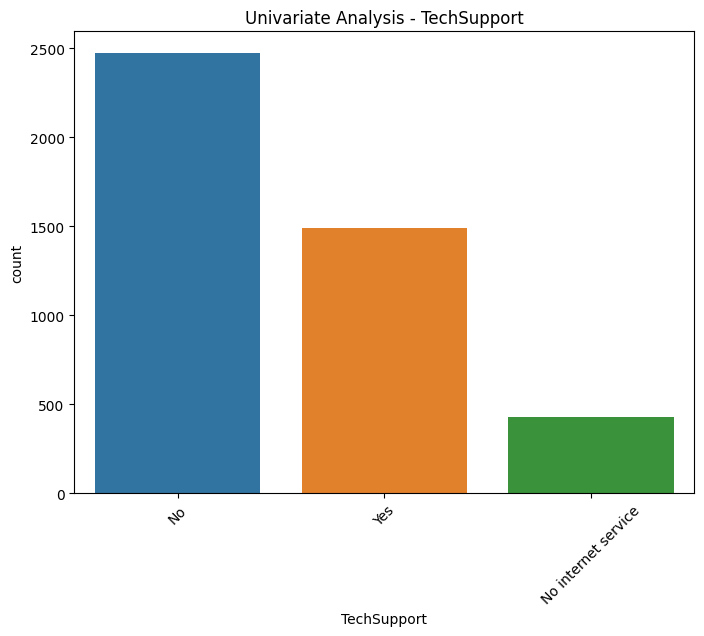

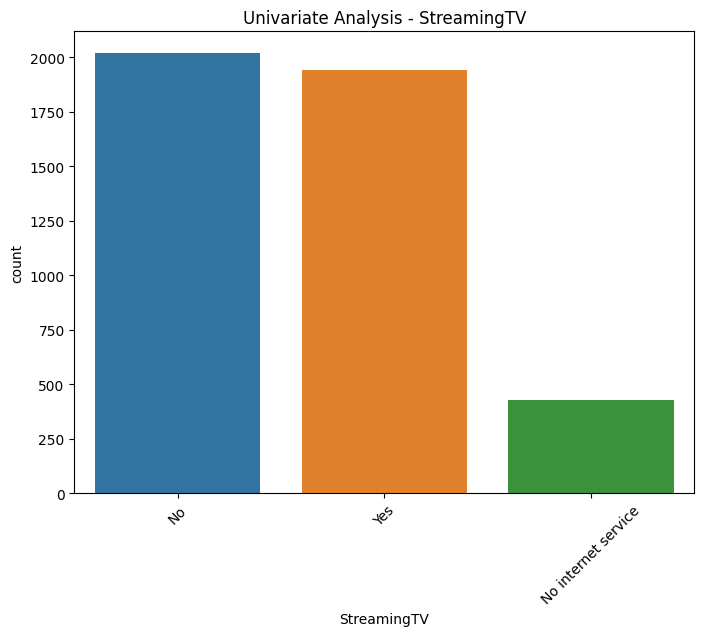

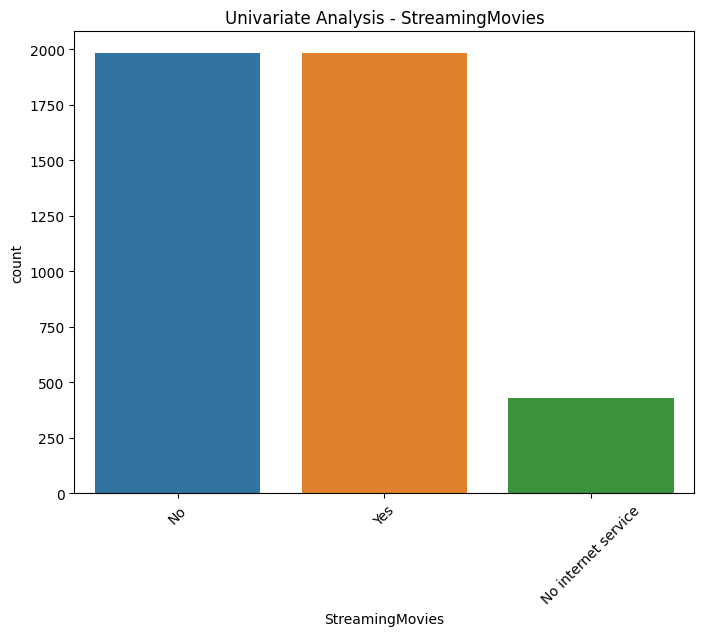

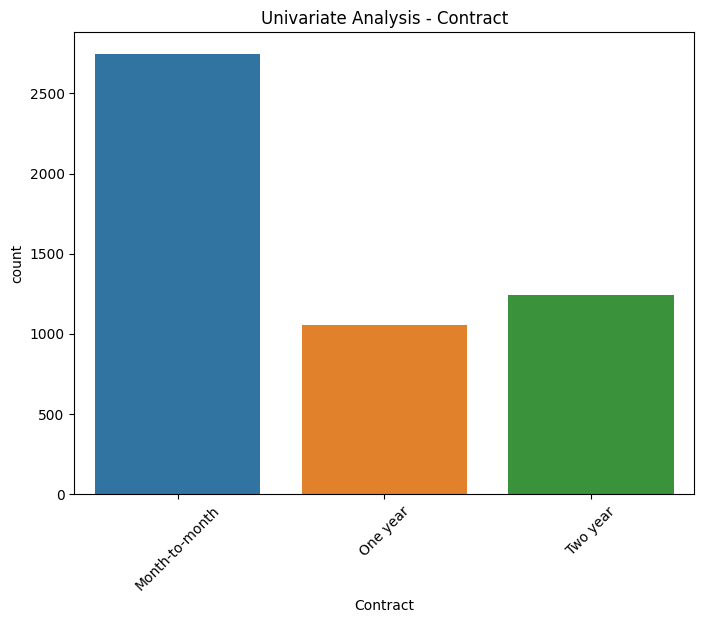

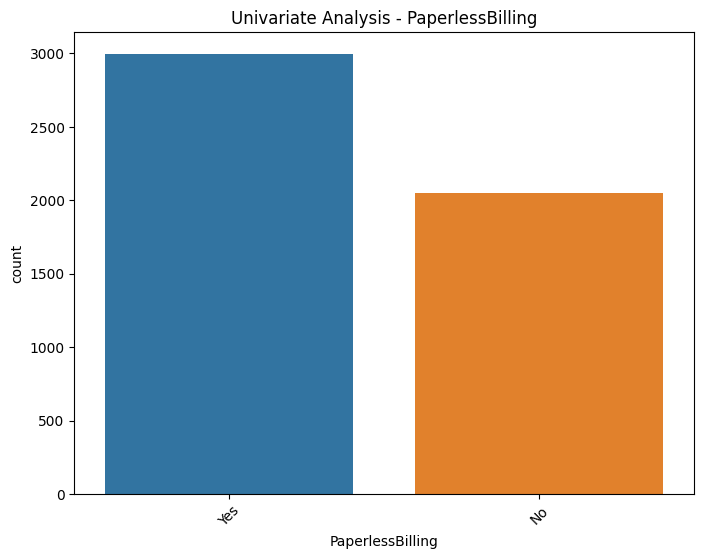

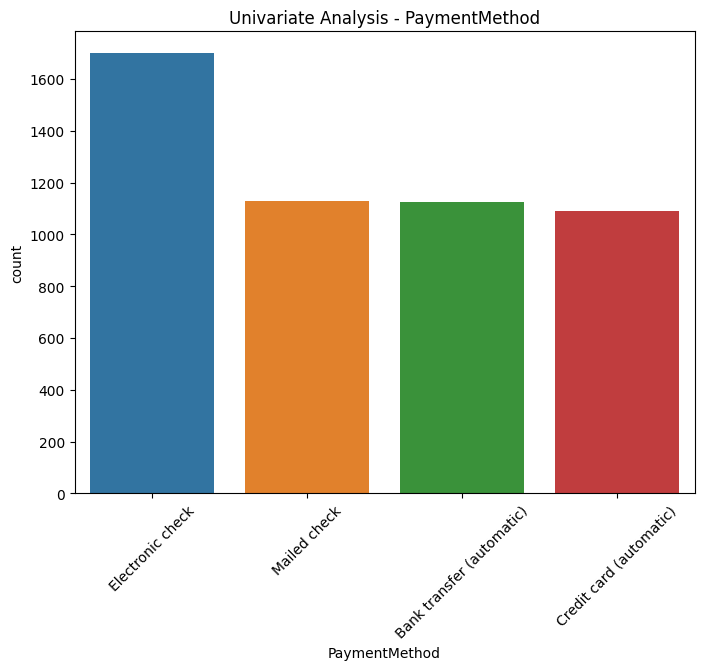

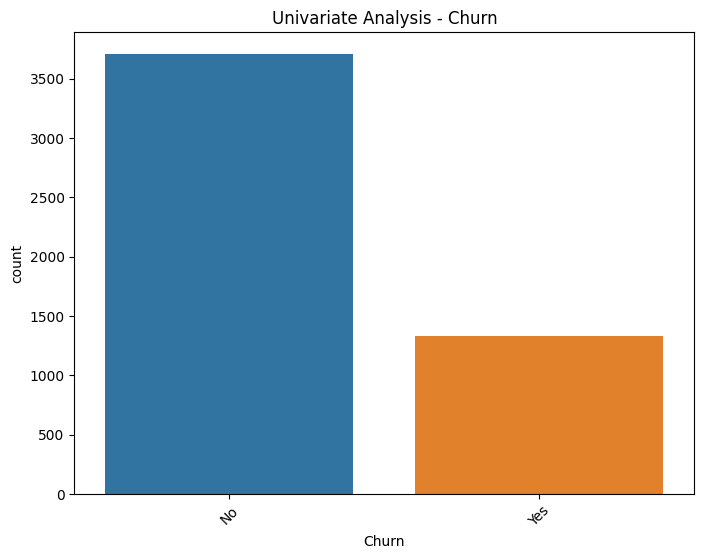

In [27]:
# Define a custom color palette (you can adjust these colors as needed)
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Loop through each categorical column and create a count plot
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=merged, palette=custom_palette)
    plt.title(f'Univariate Analysis - {column}')
    plt.xticks(rotation=45)
    plt.show()


 The Univariate analysis showed a count of the various categorical columns. An example was Is the Fiber optic being the most served internet service with over 2000 in service. Some other key idenfiers was the gender distribution being a little tilted to the Male gender.

### Bivariate Analysis

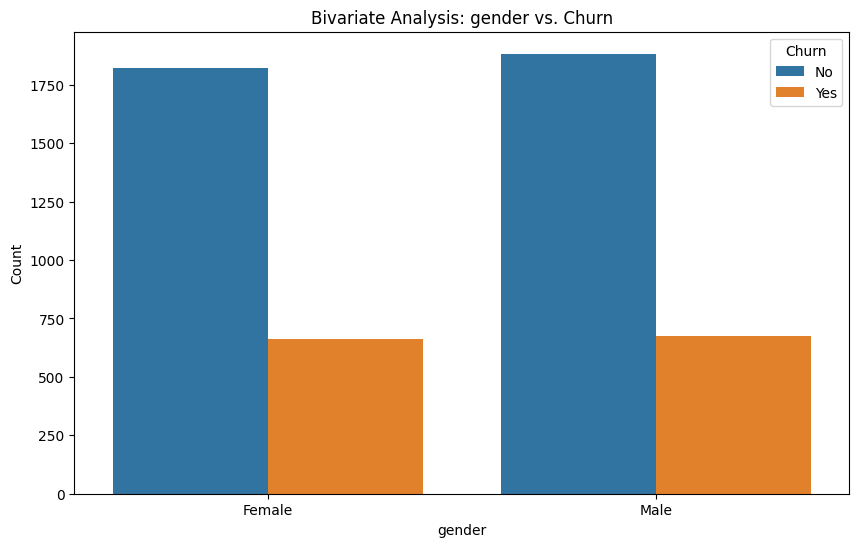

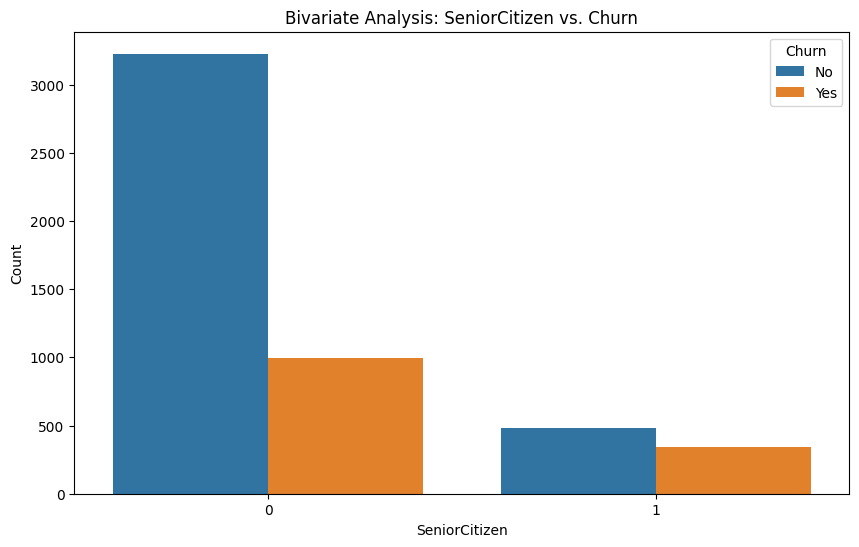

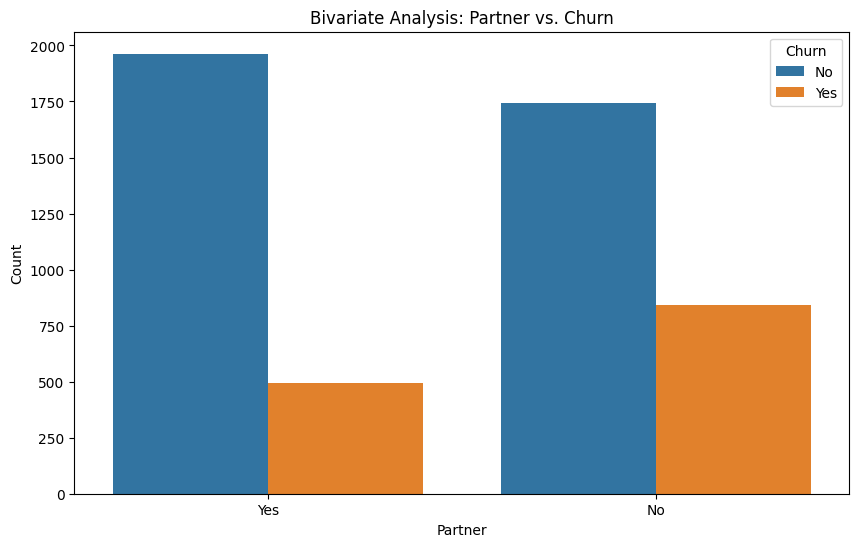

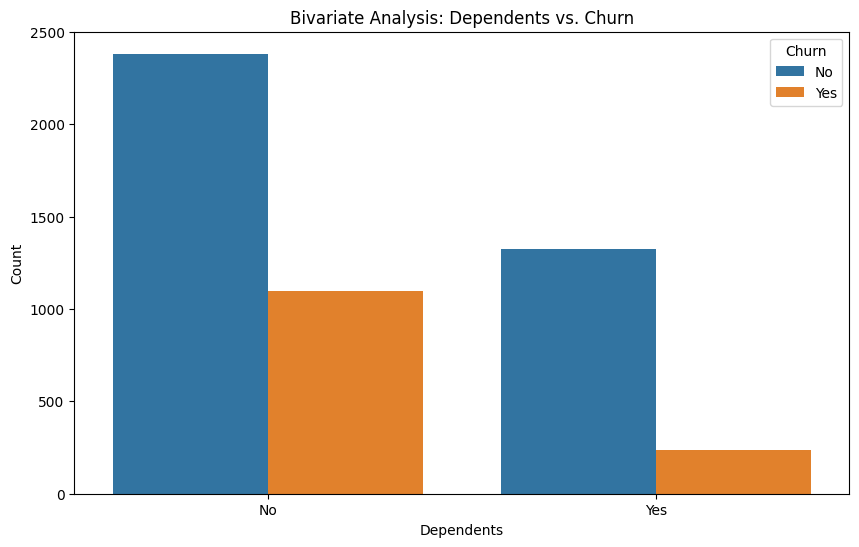

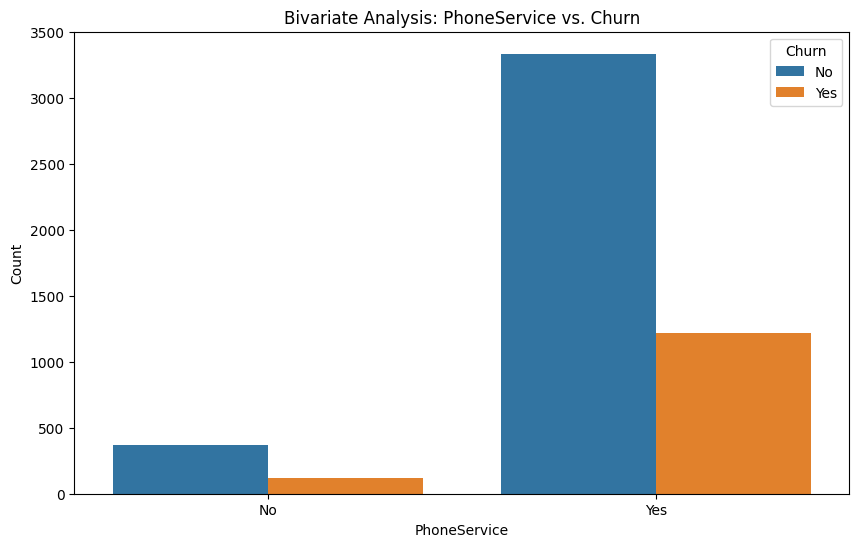

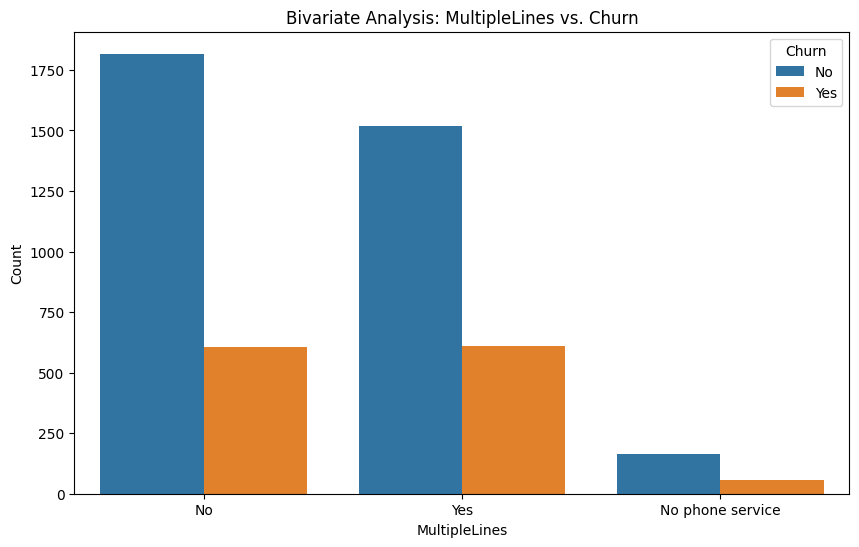

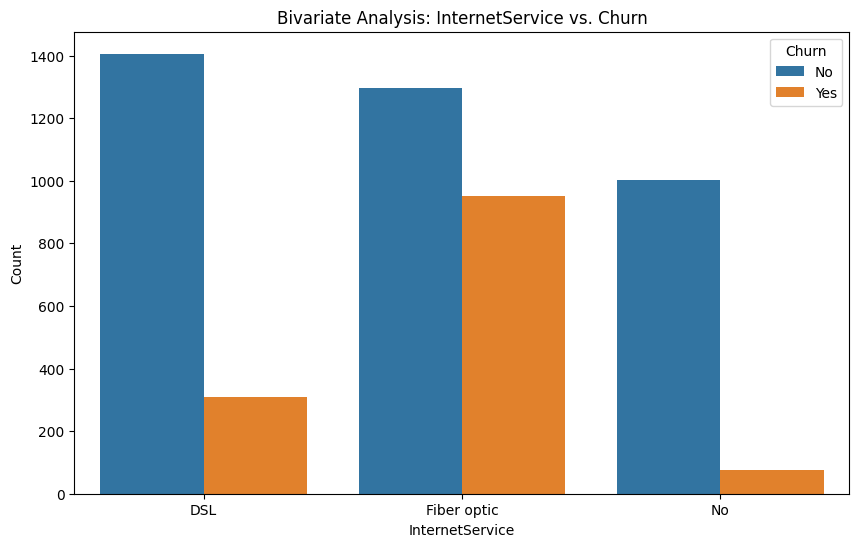

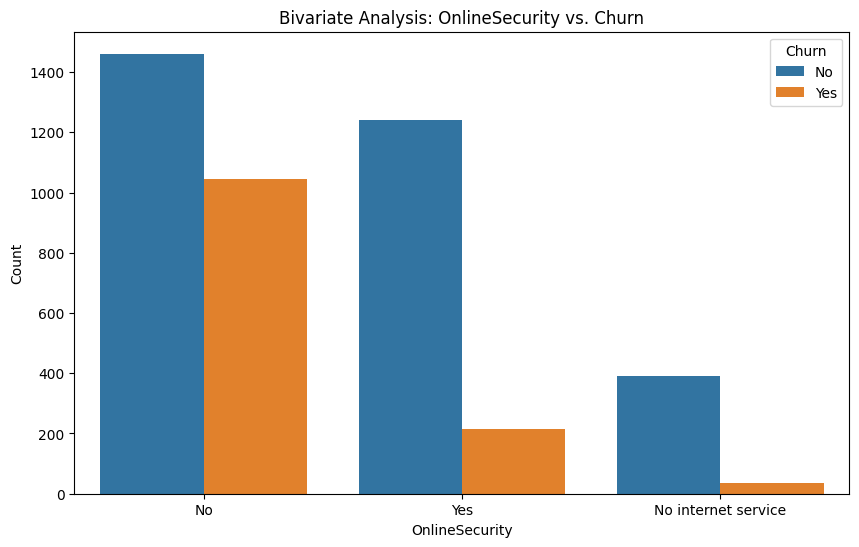

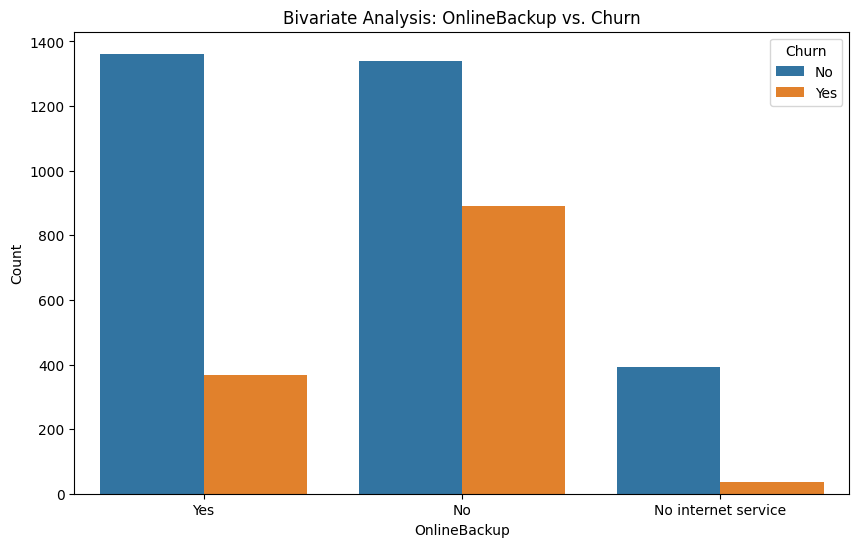

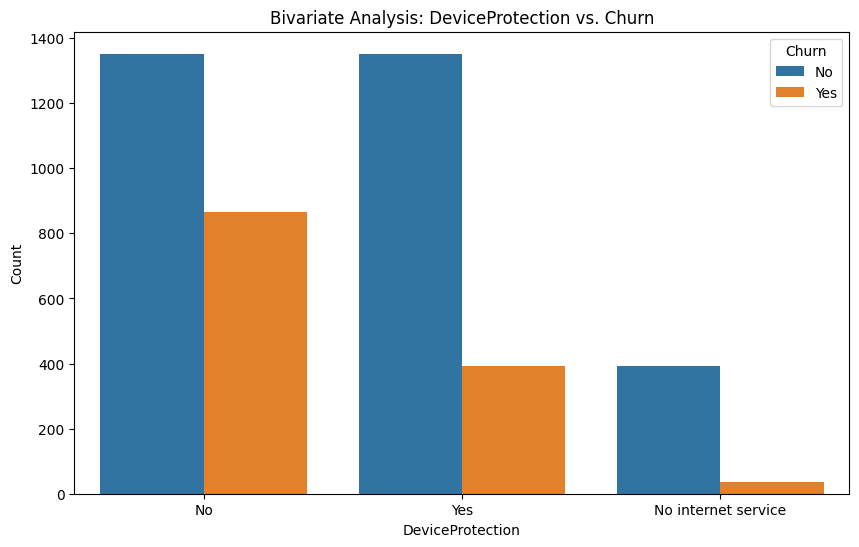

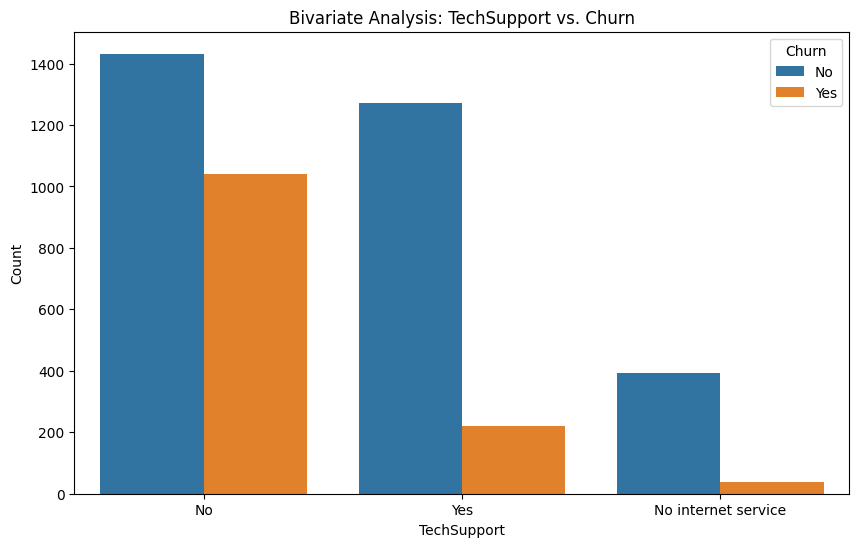

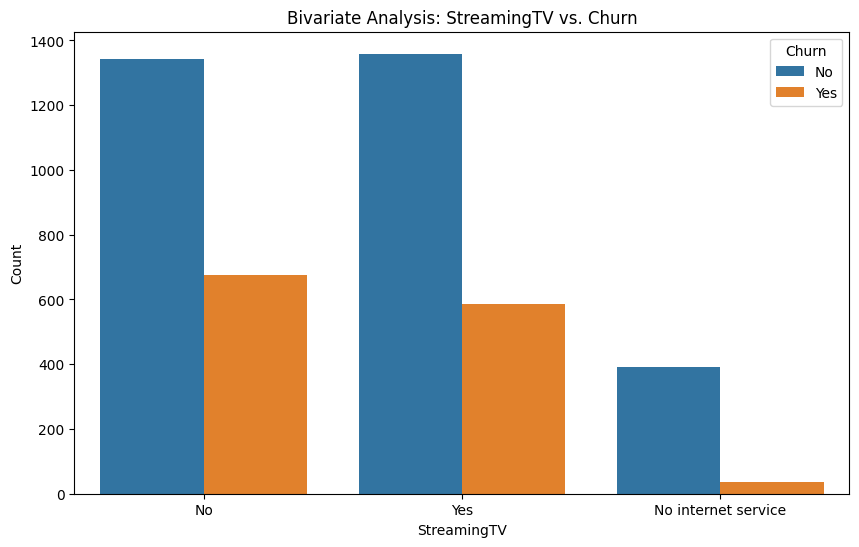

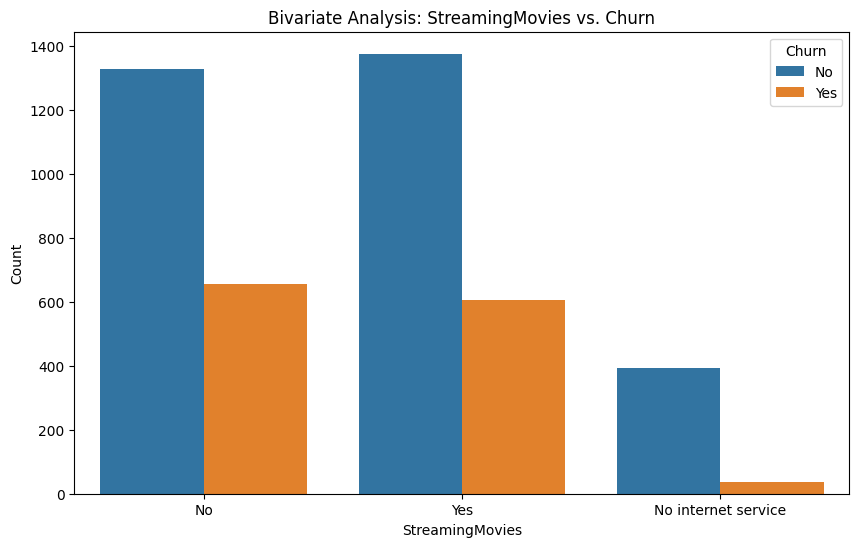

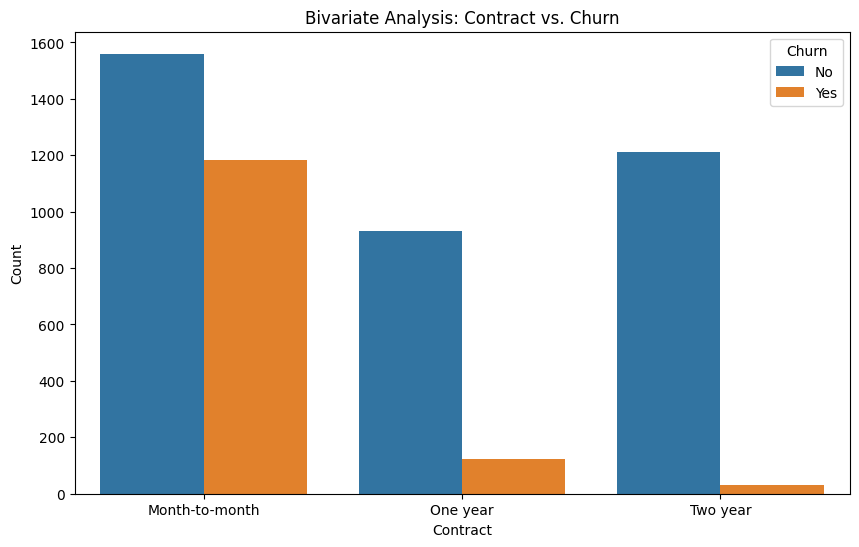

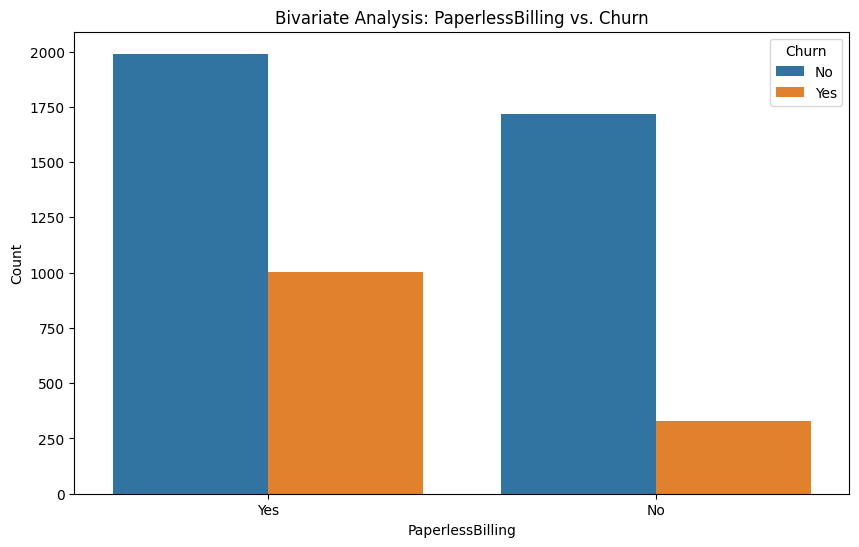

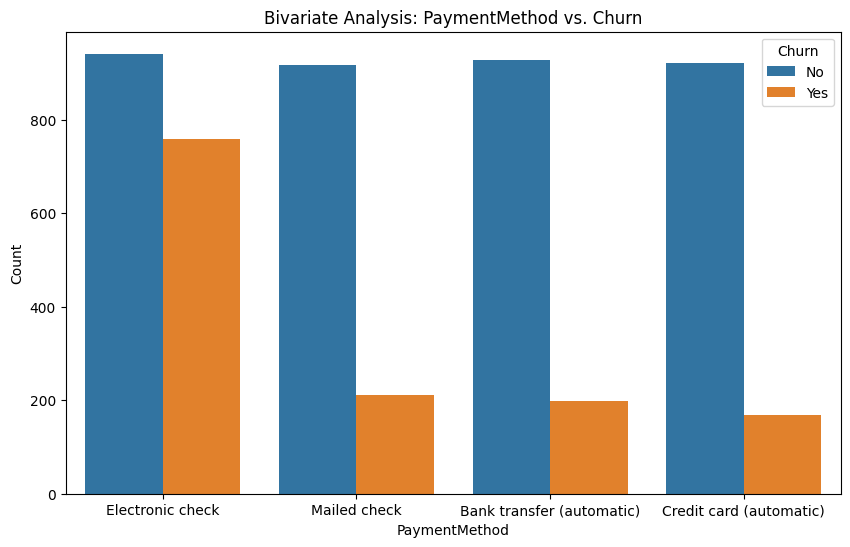

In [28]:
# Bivariate Analysis
for column in categorical_columns:
    if column != 'Churn':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, hue='Churn', data=merged)
        plt.title(f'Bivariate Analysis: {column} vs. Churn')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.legend(title='Churn', labels=['No', 'Yes'])
        plt.show()

We conducted a bivariate analysis against our churn target variable to understand the impact of various features.

The gender distribution shows an almost even spread in churn count. Among genders, males exhibited slightly higher retention in churn compared to females, although both genders averaged the same number of churned customers.

Senior citizens, according to the bivariate analysis, recorded the lowest churn rate as well as the lowest retention. In contrast, other demographics showed higher churn and retention numbers, suggesting their active participation in the Telco value chain but also their propensity to churn. The apparent stability in the senior citizen numbers may be attributed to their lower participation in the Telco space

### Multivariate analysis

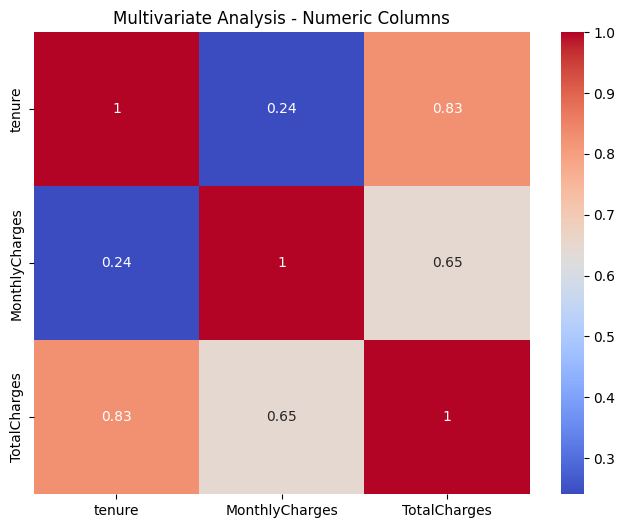

In [29]:
# Multivariate Analysis
# Numeric Columns
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(8, 6))
sns.heatmap(merged[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Multivariate Analysis - Numeric Columns')
plt.show()


 - The coefficients indicate a **positive linear relationship between tenure and MonthlyCharges**, as well as between **MonthlyCharges and TotalCharges**. This suggests that customers with longer tenure generally have higher monthly charges and total charges, whereas those with shorter tenure tend to have lower monthly and total charges.

### Check Churn rate

In [30]:
# Target Variable distribution by percentage
100*merged['Churn'].value_counts()/len(merged['Churn'])

Churn
No     73.502578
Yes    26.497422
Name: count, dtype: float64

The data indicates that for Vodafone telecommunications, 26.49% of customers rate churned, while 73.49%  stayed. This suggests a relatively high churn rate, which could signal issues with customer satisfaction, service quality, or competition.

#### Hypothesis

- *Null Hypothesis (H0):* There is no significant relationship between the type of internet service (DSL, Fiber Optic, No) and customer churn.
- *Alternative Hypothesis (H1):* There is a significant relationship between the type of internet service (DSL, Fiber Optic, No) and customer churn.

In [31]:

# Create a contingency table
contingency_table = pd.crosstab(merged['InternetService'], merged['Churn'])

# Perform the Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

# Conclusion
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis (H0). There is a significant relationship between the type of internet service and customer churn.")
else:
    print("Fail to reject the null hypothesis (H0). There is no significant relationship between the type of internet service and customer churn.")

Chi-Square Statistic: 562.2698920653917
p-value: 8.028682205375917e-123
Degrees of Freedom: 2
Expected Frequencies:
 [[1260.56921856  454.43078144]
 [1651.60293534  595.39706466]
 [ 793.82784609  286.17215391]]
Reject the null hypothesis (H0). There is a significant relationship between the type of internet service and customer churn.


Given the p-value is far less than the standard significance levels of 0.05, we reject the null hypothesis. This means there is strong evidence to support the claim that there is a significant relationship between the type of internet service and customer churn.

### Analytical Questions

### Question 1. What is the relationship between the charges and customers' churn?

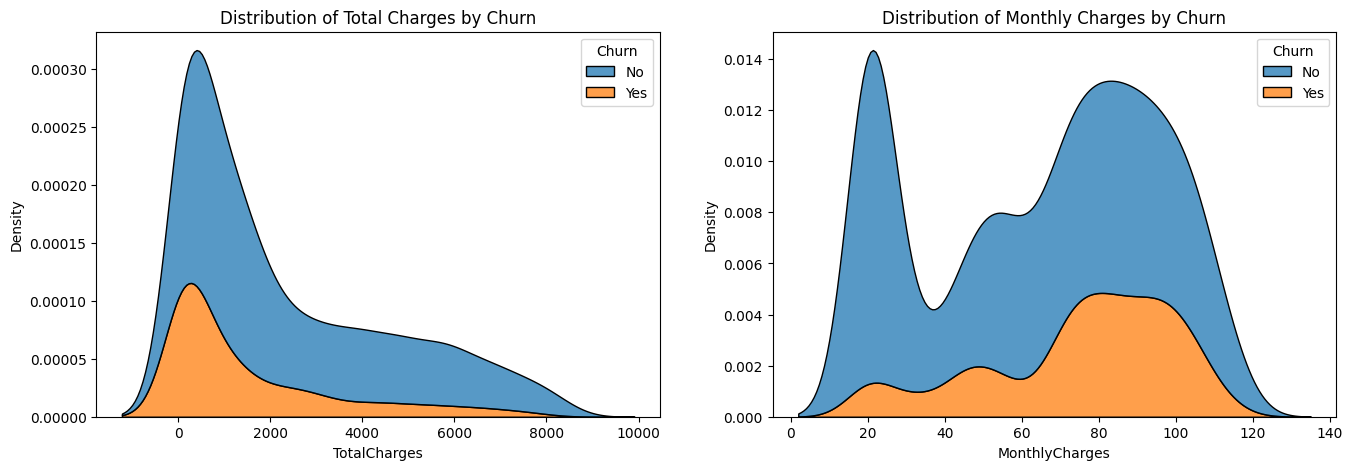

In [32]:
plt.figure(figsize=[16, 5])
plt.subplot(1,2, 1)
sns.kdeplot(data=merged, x="TotalCharges", hue="Churn", multiple='stack')
plt.title('Distribution of Total Charges by Churn')

plt.subplot(1,2, 2)
sns.kdeplot(data=merged, x="MonthlyCharges", hue="Churn", multiple='stack')
plt.title('Distribution of Monthly Charges by Churn');
plt.show()

### Question 2: What are the demographic characteristics of customers who are more likely to churn?
   

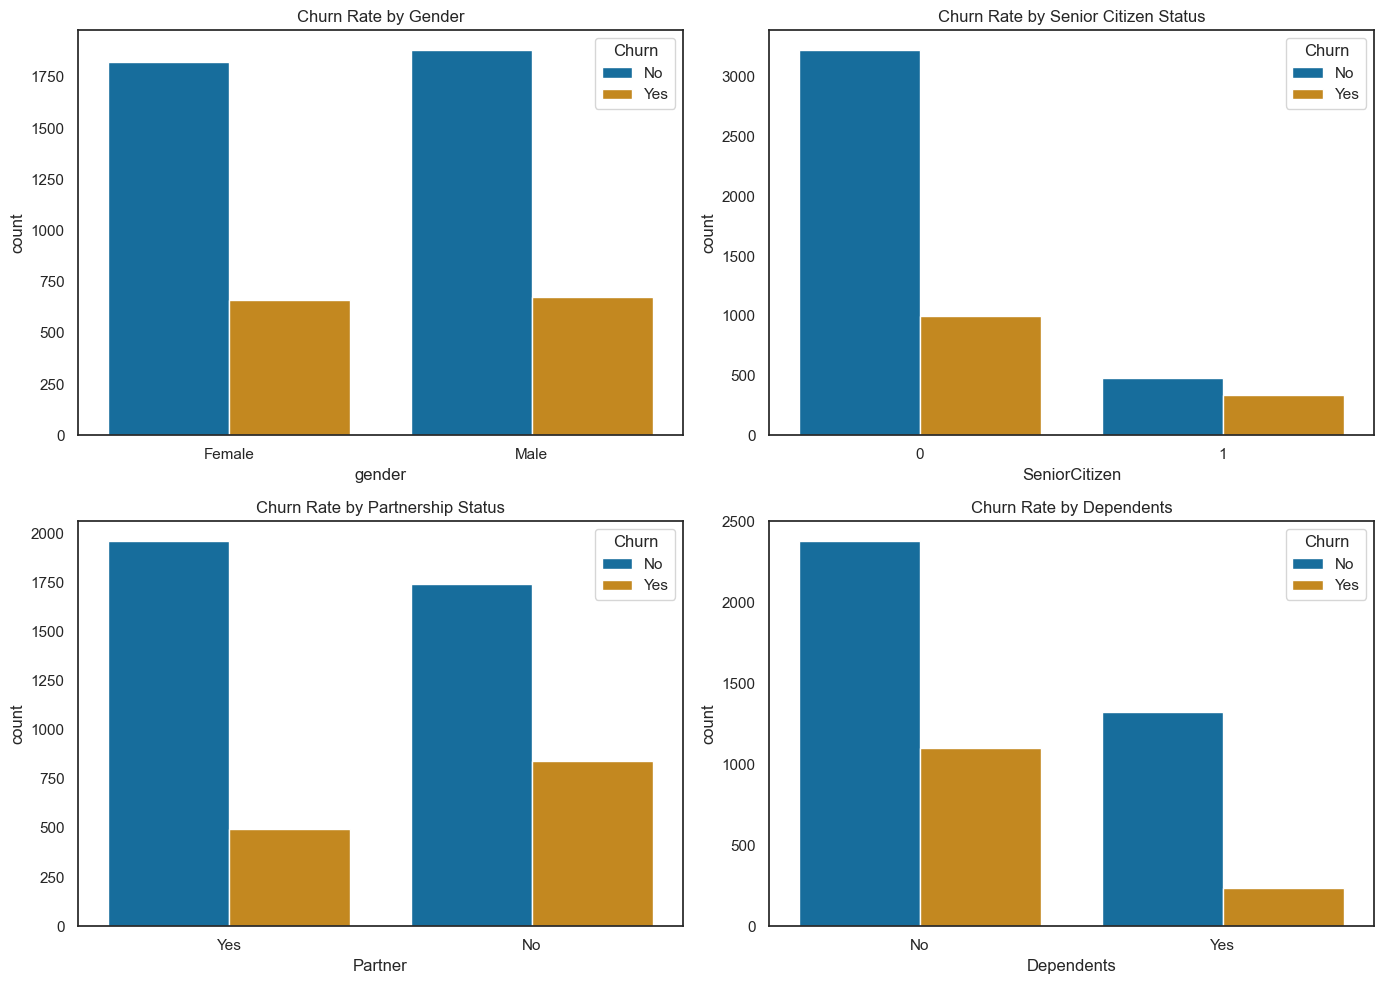

In [33]:
# Set the style and color palette
sns.set(style="white")
color_palette = sns.color_palette("colorblind")

# Create a figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Churn rate by gender
sns.countplot(x='gender', hue='Churn', data=merged, ax=axs[0, 0], palette=color_palette)
axs[0, 0].set_title('Churn Rate by Gender')
axs[0, 0].grid(False)

# Plot 2: Churn rate by senior citizen status
sns.countplot(x='SeniorCitizen', hue='Churn', data=merged, ax=axs[0, 1], palette=color_palette)
axs[0, 1].set_title('Churn Rate by Senior Citizen Status')
axs[0, 1].grid(False)

# Plot 3: Churn rate by partnership status
sns.countplot(x='Partner', hue='Churn', data=merged, ax=axs[1, 0], palette=color_palette)
axs[1, 0].set_title('Churn Rate by Partnership Status')
axs[1, 0].grid(False)

# Plot 4: Churn rate by dependents
sns.countplot(x='Dependents', hue='Churn', data=merged, ax=axs[1, 1], palette=color_palette)
axs[1, 1].set_title('Churn Rate by Dependents')
axs[1, 1].grid(False)

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()


### Question 3: What is the correlation between the Churn column and the rest of the features?

In [34]:
data_copy = merged.copy() # set a copy of the data frame

def categorical(data):
    '''This function change data types objects into numerical codes'''
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].astype('category')
            data[col] = data[col].cat.codes



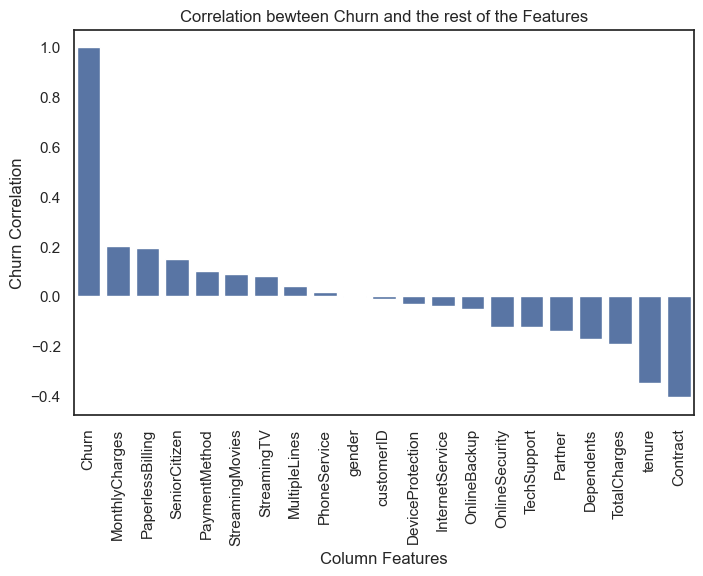

In [35]:
categorical(data_copy)
# get the correlation between all feature and churn column
churn_corr_df = data_copy.corr()[['Churn']].sort_values(by='Churn', ascending=False)

color = sns.color_palette()[0] # get the first color in the seaborn color palette
plt.figure(figsize=(8,5))
# create a barplot for the churn-correlation
sns.barplot(data=churn_corr_df, x=churn_corr_df.index, y='Churn', color=color)
plt.title('Correlation bewteen Churn and the rest of the Features')
plt.ylabel('Churn Correlation')
plt.xlabel('Column Features')
plt.xticks(rotation=90)
plt.show()

### Question 4: Does the type of internet service influence customer churn

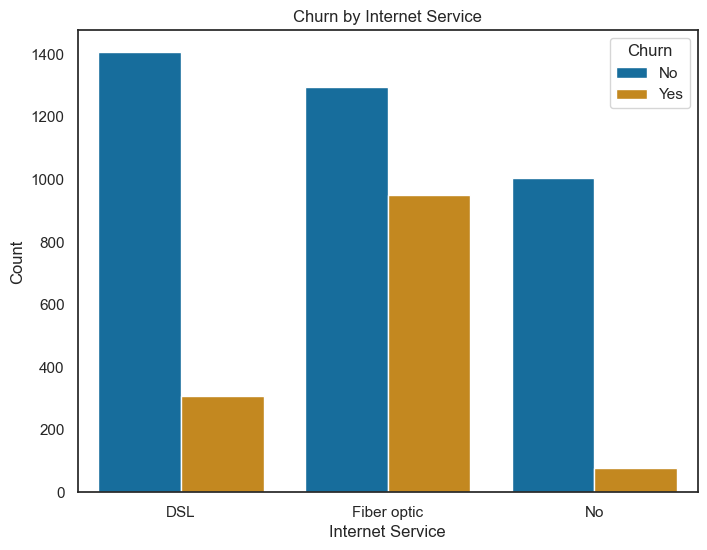

In [36]:
color_palette = sns.color_palette("colorblind")
plt.figure(figsize=(8, 6))
sns.countplot(x='InternetService', hue='Churn', data=merged, palette=color_palette)
plt.title('Churn by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.show()

The results of the visualization indicate that customers with DSL internet service have the highest number of non-churned customers, with a count of 1400. On the other hand, the count of churned customers for DSL internet service is 300. 

This suggests that customers with DSL internet service are less likely to churn compared to other internet service types. Optics, on the other hand, has a lower count of non-churned customers and a higher count of churned customers. 

In summary, the type of internet service does seem to influence customer churn, with DSL internet service showing a lower churn rate compared to other types.

### Question 5. Are customers with a longer tenure less likely to churn 

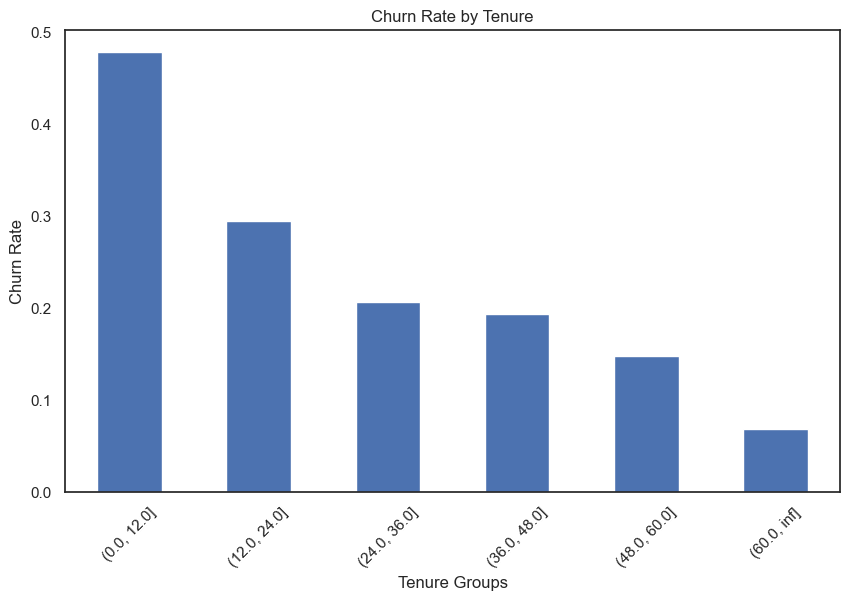

In [37]:
# Calculate churn rate for different tenure groups
tenure_groups = merged.groupby(pd.cut(merged['tenure'], bins=[0, 12, 24, 36, 48, 60, float('inf')]))
churn_rate = tenure_groups['Churn'].value_counts(normalize=True).unstack()['Yes']

# Plot the churn rate
plt.figure(figsize=(10, 6))
churn_rate.plot(kind='bar')
plt.title('Churn Rate by Tenure')
plt.xlabel('Tenure Groups')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

Customers with a tenure of 0-12 months have the highest churn rate above 0.4. This indicates that customers who are relatively new to the service are more likely to churn. It could be because they are still in the early stages of evaluating the service or may have encountered issues that led to dissatisfaction.

Customers with a tenure of 24-36 months have a lower churn rate of 0.2. This suggests that customers who have been with the service for a moderate amount of time are less likely to churn compared to those with shorter tenures. 

Customers with a tenure of 60 months and above have the lowest churn rate of 0.05. This indicates that customers who have been with the service for a longer duration are significantly less likely to churn. These customers have likely developed a strong relationship with the service provider, are satisfied with the service, and may have a higher level of loyalty. 

In summary, the results suggest that there is a correlation between tenure and churn rate. Customers with longer tenures are indeed less likely to churn compared to those with shorter tenures. 

### Question 6. Does payment method affect churn rate?

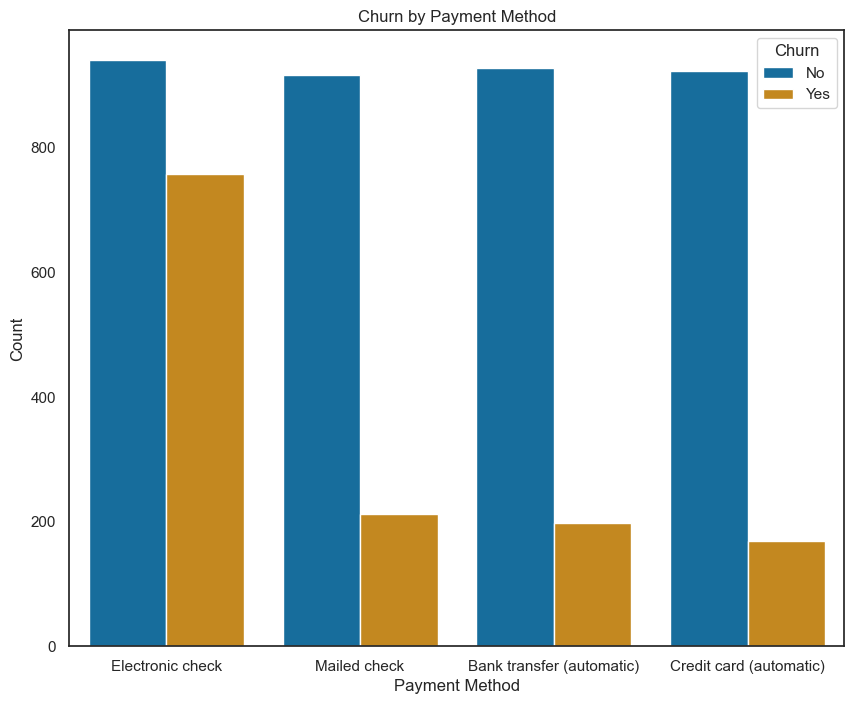

In [38]:
color_palette = sns.color_palette("colorblind")
plt.figure(figsize=(10, 8))
sns.countplot(x='PaymentMethod', hue='Churn', data=merged, palette=color_palette)
plt.title('Churn by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.show()

The results of the visualization indicate that the payment method of "Electronic check" has the highest count of both non-churned and churned customers, with approximately 900 non-churned and 750 churned customers. On the other hand, the payment methods "Mail check," "Bank transfer (automatic)," and "Credit card (automatic)" have a relatively similar number of customers at around 900, but their churn count is significantly lower at approximately 200.

This suggests that the payment method of "Electronic check" has a higher churn rate compared to other payment methods. Customers who use electronic checks as their payment method are more likely to churn compared to customers who use other payment methods such as mail check, bank transfer (automatic), or credit card (automatic).

In summary, the payment method does seem to influence customer churn, with electronic check users having a higher churn rate compared to other payment methods.

### Data Preparation

In [39]:
# Use pandas.DataFrame.drop_duplicates method
merged.duplicated().sum()

0

### - Drop CustomerID because its irrelevant to the modeling process.

In [40]:
# Drop CustomerID because of it limitations
merged.drop(columns=['customerID'], inplace=True)


In [41]:

X = merged.drop('Churn',axis=1)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002
3,Male,0,No,No,45,No,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994


In [42]:
# y-output to column of interest
y = merged['Churn']
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

In [43]:
# Confirm unique value
y.unique()

array(['No', 'Yes'], dtype=object)

In [44]:
# Confirm columns asign to X
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

### Split Data into Categorical and Numerical columns

In [45]:
# Group numerical columns 
numerical_columns = X.select_dtypes('number').columns
numerical_columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [46]:
# Group categorical columns
categorical_columns = X.select_dtypes('object').columns
categorical_columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [47]:
# Assuming X and y are your feature matrix and target vector respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


### Encode

In [48]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [49]:
# Check skewness to decide which scaler to use 
X.select_dtypes('number').skew()

SeniorCitizen     1.830907
tenure            0.225416
MonthlyCharges   -0.238663
TotalCharges      0.944216
dtype: float64

 - Decision
 
ReobustScaler because of the biases in the X_train data.

In [50]:
# Check if the are zero values or not to decide the type of transformation
X.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5042.0,0.162436,0.368886,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5042.0,32.568822,24.525954,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5042.0,65.081376,30.064564,18.400000,35.762500,70.550003,90.050002,118.650002
TotalCharges,5034.0,2300.954758,2268.346402,18.799999,417.662498,1401.000000,3860.599976,8670.100000


### Pipeline

In [51]:
# create pipeline to take care of numerical data
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('power-transformation', PowerTransformer(method='yeo-johnson')),
])

# create pipeline to take care of categorical data
categoric_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore') )
])  

#combine the two pipelines together
preprocessor = ColumnTransformer(transformers=[
    ('num_pipeline', numeric_pipeline, numeric_columns),
    ('cat_pipeline', categoric_pipeline, categorical_columns)
])

In [52]:
# Confrm pipeline 
preprocessor

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler()),
                                                 ('power-transformation',
                                                  PowerTransformer())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])

### Modeling & Evaluation

In [53]:
models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVC', SVC(random_state=42, probability=True)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistics Regression', LogisticRegression(random_state=42))
]

### Training on unbalanced datasets

In [54]:
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train_encoded)
    y_pred = pipeline.predict(X_test)

    print(f'Model: {model_name}')
    print(classification_report(y_test_encoded, y_pred))
    print('=' * 50)
    

Model: Decision Tree
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       742
           1       0.47      0.53      0.50       267

    accuracy                           0.72      1009
   macro avg       0.65      0.66      0.65      1009
weighted avg       0.73      0.72      0.72      1009

Model: SVC
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       742
           1       0.68      0.53      0.59       267

    accuracy                           0.81      1009
   macro avg       0.76      0.72      0.73      1009
weighted avg       0.80      0.81      0.80      1009

Model: Random Forest
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       742
           1       0.62      0.50      0.55       267

    accuracy                           0.79      1009
   macro avg       0.72      0.70      0.71      1009
weighted avg       0.

 - Before hyperparameter tuning, SVC exhibited the best overall performance with an accuracy of 81% and good precision-recall balance, particularly for class 0 (precision: 84%, recall: 91%). Whereas, Logistic Regression also performed well with an accuracy of 80%, showing consistent precision for class 0 (85%) and class 1 (65%). Random Forest achieved an accuracy of 79% but showed lower recall for class 1 (50%), indicating room for improvement in distinguishing positive cases

### Advance Model Evaluation and Visualization of Model Performance

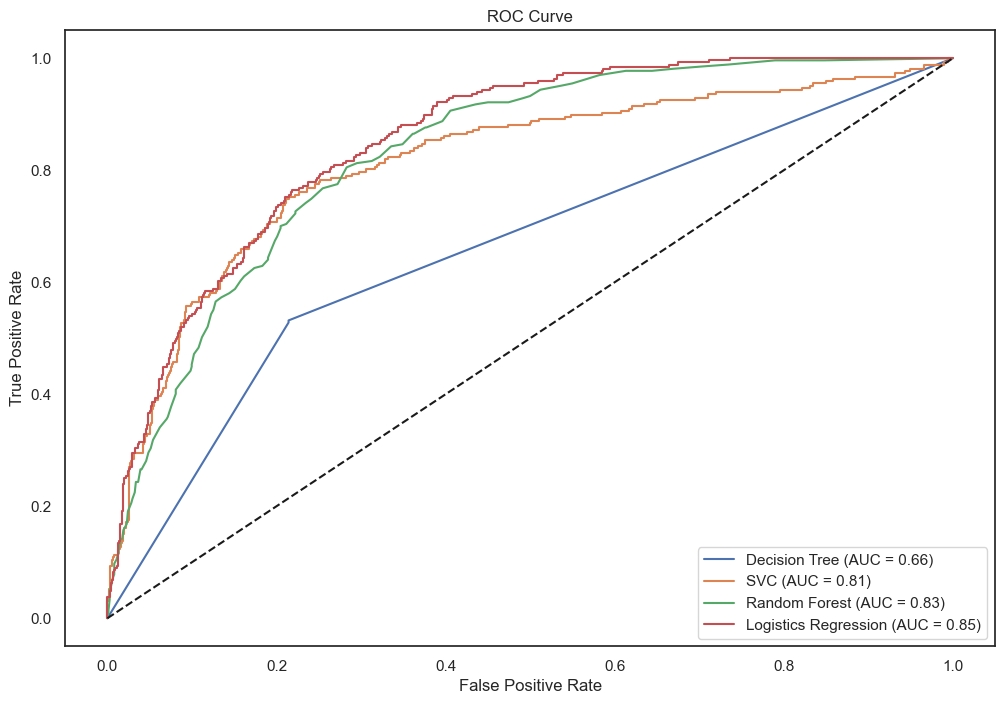

In [55]:

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    for model_name, classifier in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train, y_train_encoded)
        y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        fpr, tpr, _ = roc_curve(y_test_encoded, y_prob)
        auc = roc_auc_score(y_test_encoded, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(models, X_test, y_test_encoded)


 - The Area Under the Curve (AUC) indicates how well the four models are capable of distinguishing between classes.

  Comparatively:
 
  The Decision Tree model has the lowest AUC score (0.66) among the four models. This suggests that the model has limited ability to distinguish between classes, with moderate predictive power. In contrast, the Logistic Regression model demonstrates the best performance in distinguishing between classes, with an AUC score of 0.85, indicating high predictive power. Notably, the Random Forest and SVC models also perform well, showing high predictive power with AUC scores of 0.83 and 0.81, respectively.


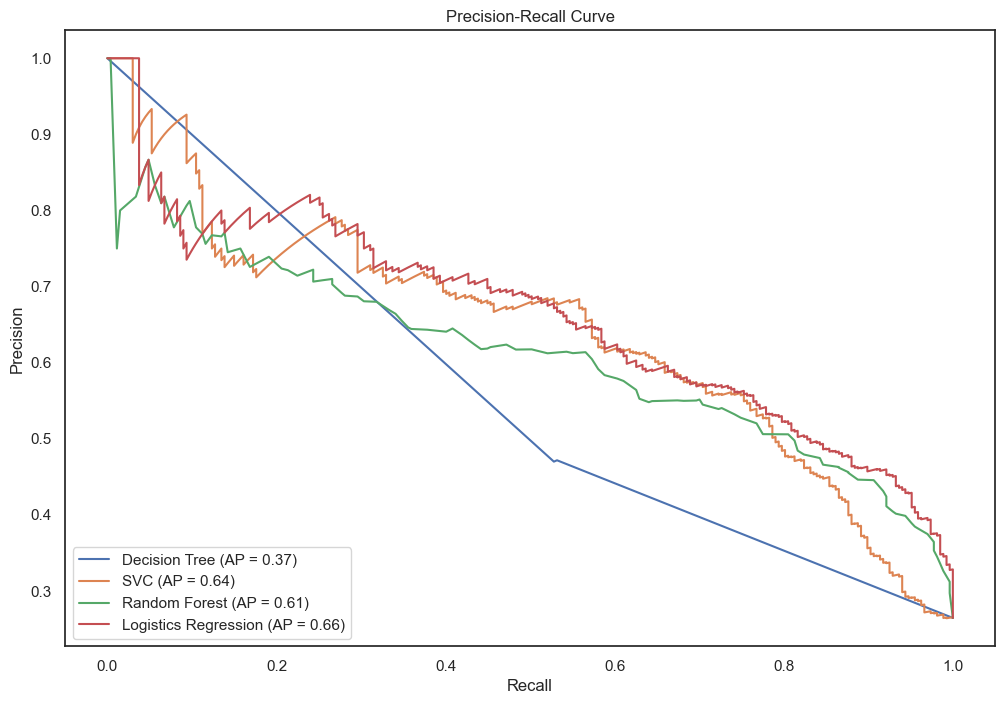

In [56]:
def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    for model_name, classifier in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train, y_train_encoded)
        y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        precision, recall, _ = precision_recall_curve(y_test_encoded, y_prob)
        avg_precision = average_precision_score(y_test_encoded, y_prob)
        plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

plot_precision_recall_curve(models, X_test, y_test_encoded)


 - The Average Precision (AP) scores from the precision-recall curves provide further insight into the models' performance by illustrating the trade-off between precision and recall at various threshold levels. Graphically Logistic Regression outperforms the other models in both AUC and AP scores, indicating that it has the highest predictive power and the best balance between precision and recall

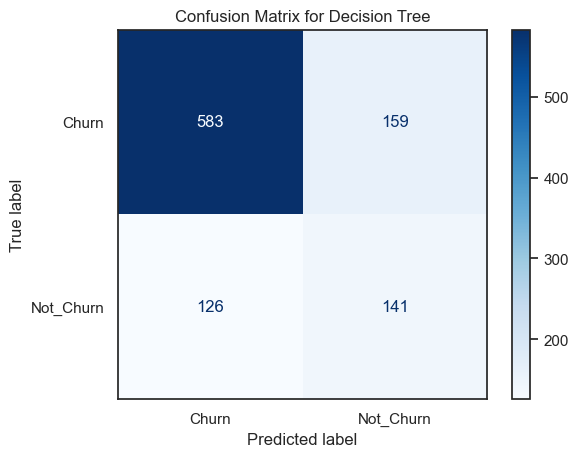

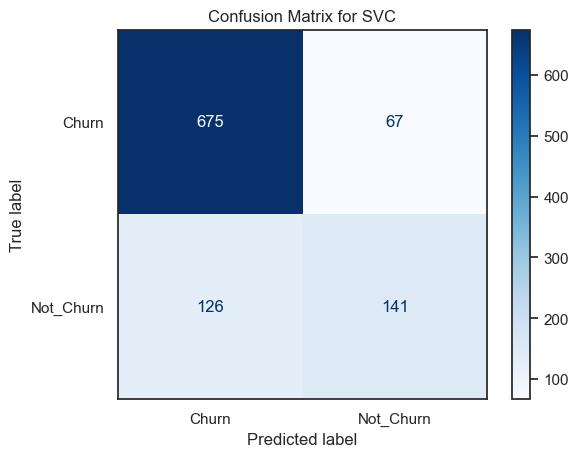

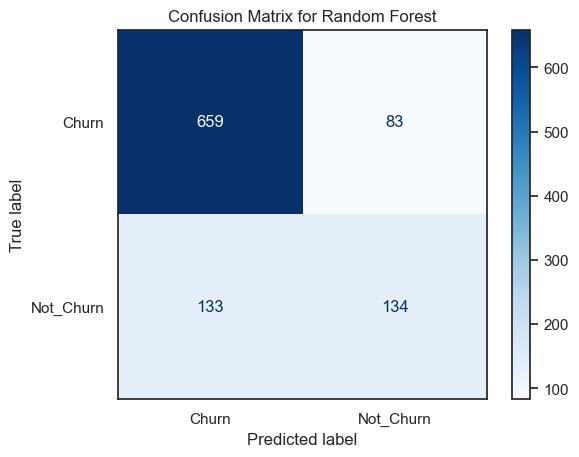

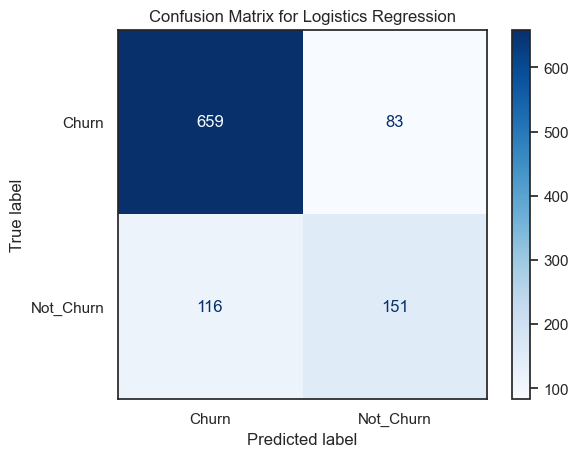

In [57]:
def plot_confusion_matrix(models, X_test, y_test):
    for model_name, classifier in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train, y_train_encoded)
        y_pred = pipeline.predict(X_test)
        cm = confusion_matrix(y_test_encoded, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn', 'Not_Churn'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

plot_confusion_matrix(models, X_test, y_test_encoded)


In [58]:
# Define the hyperparameter grids for each model
param_grids = {
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': [1, 0.1, 0.01, 0.001]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {  # Corrected key
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    }
}

# Perform Grid Search for each model
for model_name, classifier in models:
    if model_name == 'Logistics Regression':
        model_name = 'Logistic Regression'  # Correct the name to match param_grids key
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train_encoded)
    
    print(f'Model: {model_name}')
    print(f'Best Hyperparameters: {grid_search.best_params_}')
    print(f'Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}')
    print('=' * 50)


Model: Decision Tree
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best Cross-Validation Accuracy: 0.76
Model: SVC
Best Hyperparameters: {'classifier__C': 10, 'classifier__gamma': 0.001}
Best Cross-Validation Accuracy: 0.81
Model: Random Forest
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best Cross-Validation Accuracy: 0.81
Model: Logistic Regression
Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.81


 - Hyperparameter tuning significantly enhanced the performance of the models across Decision Tree, SVC, Random Forest, and Logistic Regression algorithms. The tuning process resulted in noticeable accuracy improvements: **Decision Tree increased from 72% to 76%**, while Random Forest and Logistic Regression both saw their **accuracy rise from 79% to 81%**. `SVC maintained a high accuracy of 81% throughout`. The enhancements underscore the importance of fine-tuning the model parameters, not only in improving accuracy but also in increasing predictive power and ensuring consistent performance across different datasets and real-world applications.

### Balance data

### `Key insights`
1. There are 3000 rows and 21 columns in the first dataset.
2. There are 2000 rows and 21 columns in the second dataset.
3. There are 5000 rows and 21 columns in the merged dataset.
4. Drop irrelevant Unamed:0 column from the merged dataset
5. TotalCharges has wrong Dtype instead of float.
6. The following columns have missing values:
     - MultipleLines        269
     - OnlineSecurity       651
     - OnlineBackup         651
     - DeviceProtection     651
     - TechSupport          651
     - StreamingTV          651
     - StreamingMovies      651
     - TotalCharges          8
     - Churn                 1
